In [46]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

from snntorch.functional.loss import ce_temporal_loss

from snntorch.functional.acc import accuracy_temporal

In [26]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:08<00:00, 1127199.72it/s]


Extracting /tmp/data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to /tmp/data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 71419.59it/s]


Extracting /tmp/data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to /tmp/data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1392097.45it/s]


Extracting /tmp/data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to /tmp/data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 502692.27it/s]

Extracting /tmp/data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to /tmp/data/mnist\MNIST\raw



In [51]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [52]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target


def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print(f"Train Set Accuracy: {acc_hist[counter]:.2f}")
    print(f"Test Set Accuracy: {test_acc_hist[counter]:.2f}")
    print("\n")

In [53]:
loss = ce_temporal_loss()
accuracy = accuracy_temporal
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

num_epochs = 1
loss_hist = []
test_loss_hist = []

acc_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        loss_val = loss(spk_rec,targets)
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        acc_val = accuracy(spk_rec,targets)
        acc_hist.append(acc_val.item())
        
        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))
            
            test_loss = loss(test_spk,test_targets)
            
            test_loss_hist.append(test_loss.item())

            test_acc_val = accuracy(test_spk,test_targets)
            test_acc_hist.append(test_acc_val.item())
            
            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 7.98
Test Set Loss: 3.68
Train Set Accuracy: 0.14
Test Set Accuracy: 0.29


Epoch 0, Iteration 50
Train Set Loss: 0.81
Test Set Loss: 0.88
Train Set Accuracy: 0.77
Test Set Accuracy: 0.79


Epoch 0, Iteration 100
Train Set Loss: 1.03
Test Set Loss: 0.81
Train Set Accuracy: 0.76
Test Set Accuracy: 0.83


Epoch 0, Iteration 150
Train Set Loss: 0.98
Test Set Loss: 0.94
Train Set Accuracy: 0.81
Test Set Accuracy: 0.81


Epoch 0, Iteration 200
Train Set Loss: 0.48
Test Set Loss: 0.51
Train Set Accuracy: 0.90
Test Set Accuracy: 0.91


Epoch 0, Iteration 250
Train Set Loss: 0.21
Test Set Loss: 0.18
Train Set Accuracy: 0.95
Test Set Accuracy: 0.93


Epoch 0, Iteration 300
Train Set Loss: 0.25
Test Set Loss: 0.32
Train Set Accuracy: 0.91
Test Set Accuracy: 0.94


Epoch 0, Iteration 350
Train Set Loss: 0.23
Test Set Loss: 0.10
Train Set Accuracy: 0.95
Test Set Accuracy: 0.95


Epoch 0, Iteration 400
Train Set Loss: 0.36
Test Set Loss: 0.16
Train Set Accuracy:

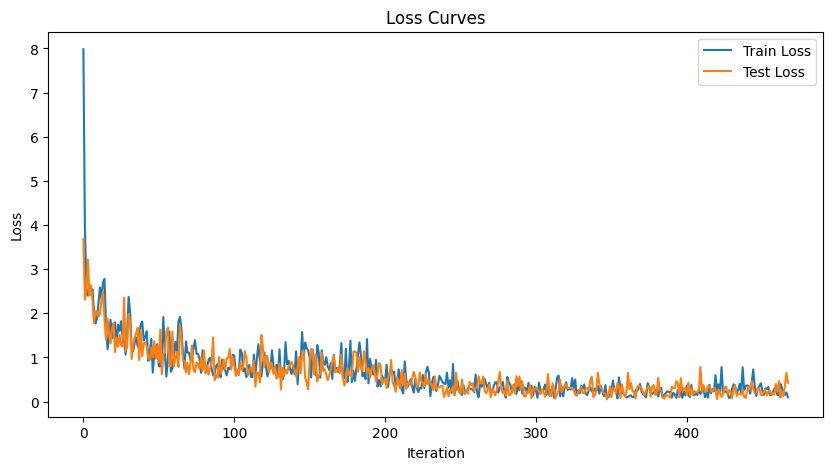

In [54]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


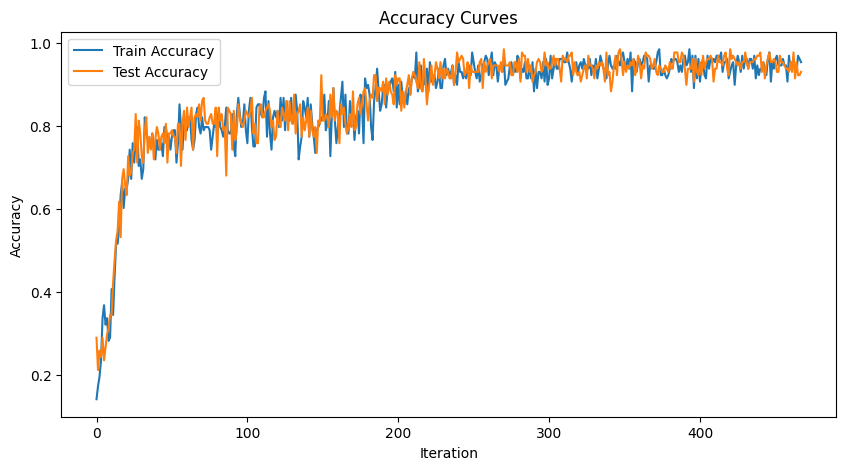

In [56]:
# Plot Accuracy
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(acc_hist)
plt.plot(test_acc_hist)
plt.title("Accuracy Curves")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()


In [57]:
np.max(acc_hist),np.max(test_acc_hist)

(0.984375, 0.984375)

In [62]:
# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=10000, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    print(accuracy(test_spk,targets))

0.9535
